# main

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':30,
    'ytick.labelsize':30,
    'axes.labelsize':40,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
dir = '../data.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Winter meeting figures

In [4]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[-1]}.csv").set_index(["id_x","id_y"]).sort_index()

In [5]:
F = 1e-4 # force density units
h = 10 # mm
rho = 1 # water density units
nu = 0.890 # (mm)²/(s)

In [6]:
uC = F/(2*rho*nu) * h**2
uC

0.0056179775280898875

In [7]:
def fluidOverview(df):
    df = df.query('coordinate_y <= 10 & coordinate_y >= -10')
    # figure preparation
    fig, axes = plt.subplots(figsize = (11,5.5))
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = df['coordinate_x'].unique()
    y_unique = df['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)

    # first plot
    upperLim = 1
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes.pcolormesh(X, Y,
        (np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2)/uC).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
    axes.set_xticks([-20, 0, 20])
    axes.set_xlabel("$x ~ (\\mu \\mathrm{m})$")
    axes.set_yticks([-10, 0, 10])
    axes.set_ylabel("$y ~ (\\mu \\mathrm{m})$")
    
    maskStep = int(len(x_unique)/20)
    # Create a mask for filtering
    mask = (df['coordinate_x'].isin(x_unique[::maskStep])) & (df['coordinate_y'].isin(y_unique[::maskStep])) & (
        (df.fluidVelocity_x**2 + df.fluidVelocity_y**2 > 1e-16)
    )
    # Filter the DataFrame
    filtered_df = df[mask]
    
    axes.quiver(
        filtered_df['coordinate_x'], 
        filtered_df['coordinate_y'], 
        (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
        (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
        scale = 30,
    )
    
    axes.axvline(-10, color = "#CA3D34", alpha = 1, linewidth=3, linestyle='dashed')

    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$\\mathbf{u}/u_c$')

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in custom_ticks])
    
    return fig, axes

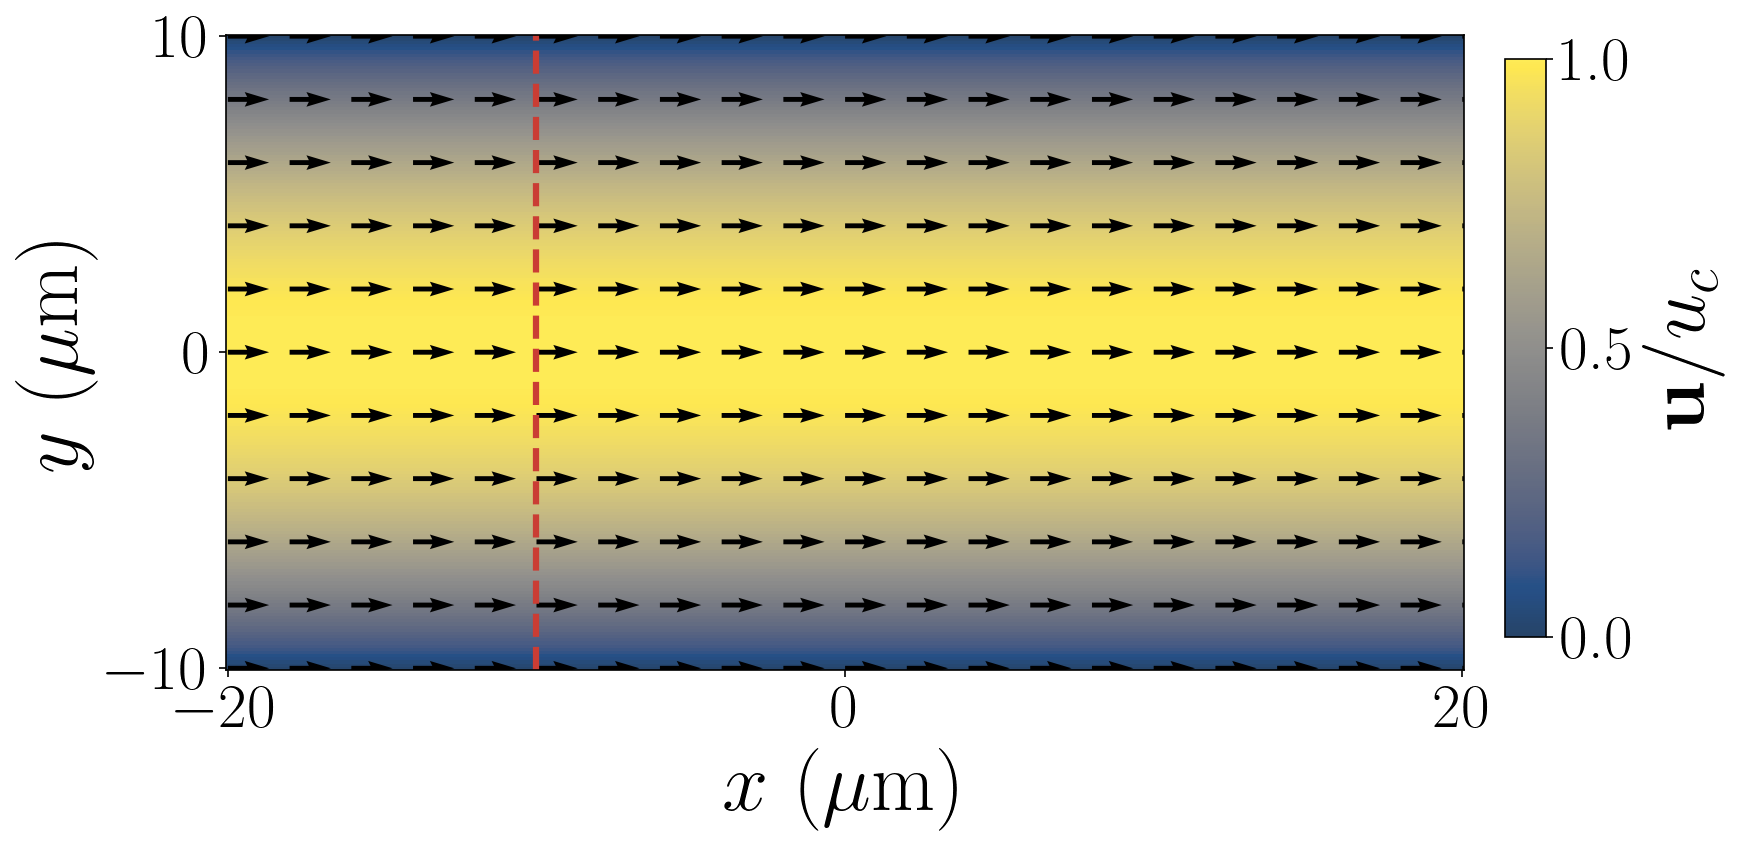

In [8]:
fig, axes = fluidOverview(fluidDf)
plt.savefig("figs/figure1.png", format="png", transparent=True, dpi=72, bbox_inches="tight")
plt.savefig("figs/figure1hd.png", format="png", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

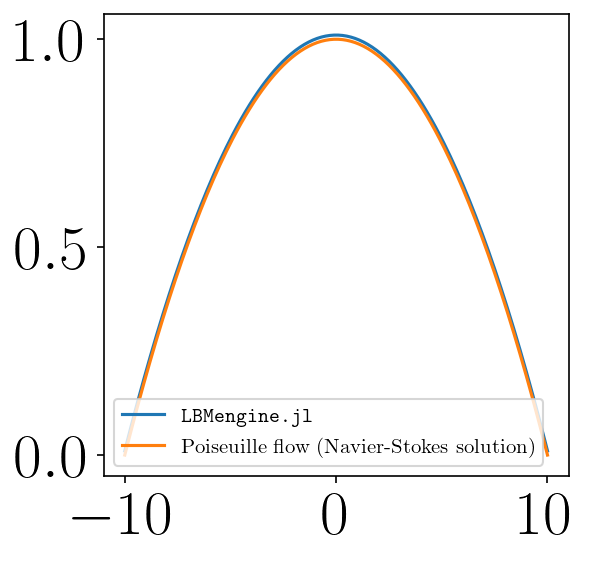

In [9]:
def figureWM(df):
    df = df.query('coordinate_y <= 10 & coordinate_y >= -10')
    
    poiseuille_v = -F/(2*rho*nu) * (df.coordinate_y**2 - h**2); poiseuille_v = (poiseuille_v + abs(poiseuille_v))/2
    
    fig, ax = plt.subplots(figsize = (4,4))

    ax.plot(df.coordinate_y, df.fluidVelocity_x/uC, label='\\texttt{LBMengine.jl}') 
    ax.plot(df.coordinate_y, poiseuille_v/uC, label='Poiseuille flow (Navier-Stokes solution)') 
    ax.set_xticks([-10, 0, 10])
    ax.set_yticks([0, 0.5, 1])
    ax.legend()
    
    return fig, ax

id = fluidDf.query("coordinate_x >= -10").reset_index().iloc[0].filter(["id_x"]).values[0]
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

fig, ax = figureWM(v_x)
plt.savefig("figs/figure2.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Stability analysis

In an effort to verify a stable equilibrium state was achieved, the mean fluid speed is studied as a function of time.

In [10]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [11]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

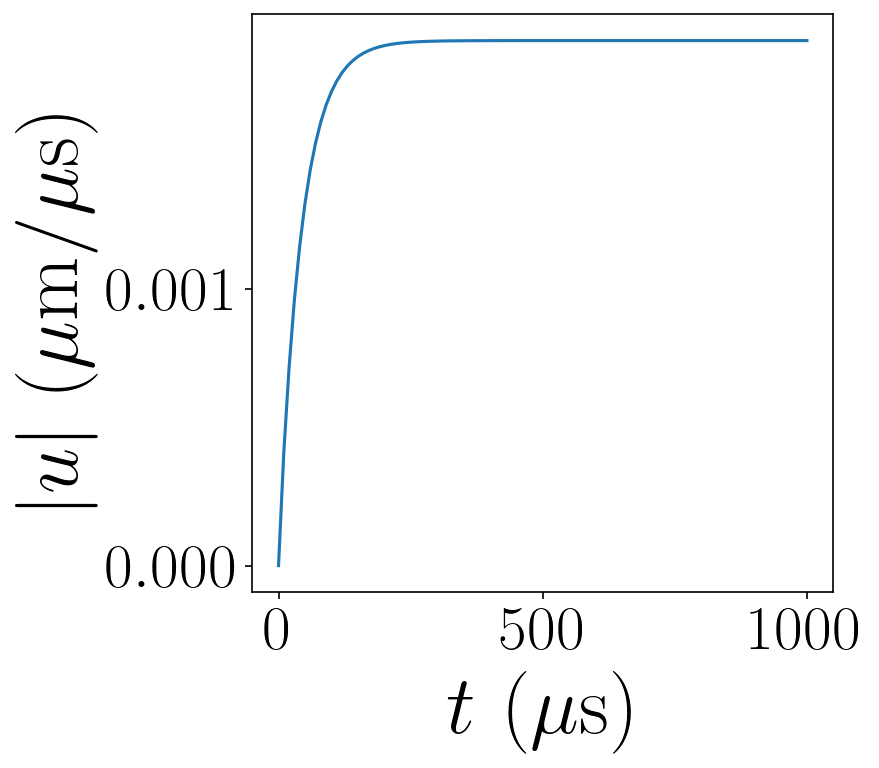

In [12]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()